## Image classification model with very little data
from this [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) 

In [2]:
import glob
import numpy as np
import cv2
import matplotlib

%matplotlib inline

In [1]:
from keras.preprocessing import image as image_utils #????
# from imagenet_utils import decode_predictions
# from imagenet_utils import preprocess_input

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


Objectives:
- train small network from scratch (as baseline)
- use bottleneck features of pre-trained network
- fine-tune top layers of pre-trained network

Keras features to cover:
- `fit_generator` (for training model using python data generators)
- `ImageDataGenerator` (for real-time data augmentation)
- layer freezing and model fine-tuning

Setup:
- Keras, SciPy, PIL installed
- NVIDIA GPU (with cuDNN installed) is nice (but not neccessary on small image set)
- training + validation data directories with one subdirectly per image class (png or jpg)

Deep learning on small-data problems:
- deep learning requires learning features automatically from data, generally only possible when lots of training data is available esp where input samples are very high-dimensional like images
- but convolutional neural networks one of best models for "perceptual problems" such as image classification even with little data to learn from
- training convnets from scrath on small image dataset will still yield reasonable results
- deep learning models are highly repurposable - you can take an image classification trained on large-scale data then reuse it on significantly different problem
- many pre-trained models (usually trained on ImageNet dataset) can be use to bootstrap powerful vision models out of very little data 

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

In [5]:
#path to images
train_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/train/'
validation_data_dir = '/Users/VanessaG/Desktop/pizza_class_data/validation'

#model paramter setup
nb_train_samples = 2000
nb_validation_samples = 800
nb_epoch = 50

In [9]:
#instantiate moel
model = Sequential()

### stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers

dim_ordering: One of {"th", "tf"}. "tf" mode means that the images should have shape (samples, width, height, channels), "th" mode means that the images should have shape (samples, channels, width, height). It defaults to the image_dim_ordering value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "tf".

In [10]:
# Because you're using tensorflow you have to put the "depth" as the 3rd dimension.
# Apparently for theano the depth comes first like in tutorial (3, 150, 150)
# and in tensorflow it comes last like (150, 150, 3)
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [11]:
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [12]:
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

### plus two fully-connected layers
We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification.

In [13]:
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

In [14]:
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [49]:
###this is to visualize output from convolutional layers
### need to modify

from keras import backend as K
from random import randint
img_to_visualize = randint(0, len(X_train) - 1)


# Generate function to visualize first layer
convout1_f = K.function([model.get_input(train=False)], convout1.get_output(train=False))
convolutions = convout1_f(reshaped[img_to_visualize: img_to_visualize+1])


%matplotlib inline
#The non-magical version of the previous line is this:
#get_ipython().magic(u'matplotlib inline')
imshow = plt.imshow #alias
plt.title("Image used: #%d (digit=%d)" % (img_to_visualize, y_train[img_to_visualize]))
imshow(X_train[img_to_visualize])


plt.title("First convolution:")
imshow(convolutions[0][0])


print "The second dimension tells us how many convolutions do we have: %s (%d convolutions)" % (
    str(convolutions.shape),
    convolutions.shape[1])


for i, convolution in enumerate(convolutions[0]):
    plt.figure()
    plt.title("Convolution %d" % (i))
    plt.imshow(convolution)

NameError: name 'X_train' is not defined

### prepare data
use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

### rescale
- value by which you mulitply the data before any other processing
- original image RGB coefficients 0-255 but these values are too high for our models to process (given a typical learning rate) so target values between 0-1 by scalling with a 1/255 factor

In [16]:
# this is the augmentation configuration we will use for training

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [17]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# does this actually create additional images? if so how many and how can you control that... 
# see image processing keras notebook for example of .flow creating additional images

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [22]:
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 800 images belonging to 2 classes.


### use these generators to train model
Fits the model on data generated batch-by-batch by a Python generator. The generator is run in parallel to the model, for efficiency. For instance, this allows you to do real-time data augmentation on images on CPU in parallel to training your model on GPU.



In [31]:
pizza_model = model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

Epoch 1/50
2000/2000 [==============================] - 79s - loss: 0.6744 - acc: 0.5965 - val_loss: 0.6215 - val_acc: 0.6525
Epoch 2/50
2000/2000 [==============================] - 73s - loss: 0.6228 - acc: 0.6775 - val_loss: 0.5397 - val_acc: 0.7238
Epoch 3/50
2000/2000 [==============================] - 73s - loss: 0.5900 - acc: 0.7110 - val_loss: 0.5350 - val_acc: 0.7712
Epoch 4/50
2000/2000 [==============================] - 73s - loss: 0.5570 - acc: 0.7390 - val_loss: 0.5325 - val_acc: 0.7350
Epoch 5/50
2000/2000 [==============================] - 74s - loss: 0.5414 - acc: 0.7410 - val_loss: 0.7256 - val_acc: 0.5625
Epoch 6/50
2000/2000 [==============================] - 73s - loss: 0.5407 - acc: 0.7380 - val_loss: 0.5973 - val_acc: 0.6713
Epoch 7/50
2000/2000 [==============================] - 74s - loss: 0.5136 - acc: 0.7615 - val_loss: 0.4852 - val_acc: 0.7750
Epoch 8/50
2000/2000 [==============================] - 74s - loss: 0.5182 - acc: 0.7495 - val_loss: 0.4416 - val_acc:

## Model stats

In [67]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 148, 148, 32)  896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 148, 148, 32)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 74, 74, 32)    0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 72, 72, 32)    9248        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [59]:
model.get_config()[:3]

[{'class_name': 'Convolution2D',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'batch_input_shape': (None, 150, 150, 3),
   'bias': True,
   'border_mode': 'valid',
   'dim_ordering': 'tf',
   'init': 'glorot_uniform',
   'input_dtype': 'float32',
   'name': 'convolution2d_1',
   'nb_col': 3,
   'nb_filter': 32,
   'nb_row': 3,
   'subsample': (1, 1),
   'trainable': True}},
 {'class_name': 'Activation',
  'config': {'activation': 'relu', 'name': 'activation_1', 'trainable': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'border_mode': 'valid',
   'dim_ordering': 'tf',
   'name': 'maxpooling2d_1',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}}]

In [32]:
model.save_weights('/Users/VanessaG/Desktop/DSI-SF-2-vnessified/capstone/keras_pizza_model.h5')

## Evaluate model results

In [51]:
## what does this mean: loss: 0.3629 - acc: 0.8465 - val_loss: 0.4519 - val_acc: 0.8037 ???? (loss)... val?

In [40]:
pizza_model.history.keys()

['acc', 'loss', 'val_acc', 'val_loss']

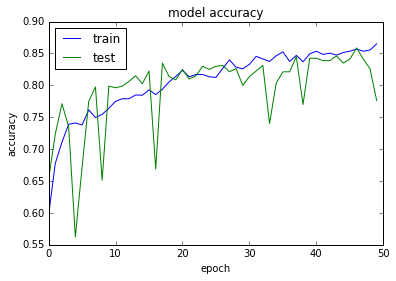

In [94]:
# summarize history for accuracy
plt.plot(pizza_model.history['acc'])
plt.plot(pizza_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

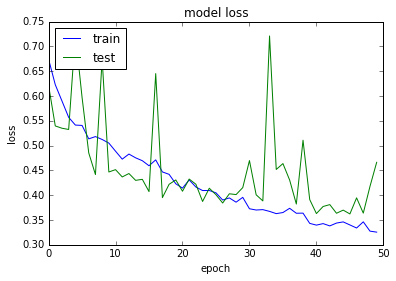

In [96]:
# summarize history for loss
plt.plot(pizza_model.history['loss'])
plt.plot(pizza_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
np.mean(pizza_model.history['acc'])

0.80617000000000005

In [71]:
model.metrics_names

['loss', 'acc']

In [98]:
#why is this different from np.mean(pizza_model.history['acc])
model.evaluate_generator(validation_generator, nb_validation_samples, max_q_size=10,
                         nb_worker=1)

[0.46632025957107542, 0.77625]

In [99]:
predictions = model.predict_generator(validation_generator, nb_validation_samples,
                                      max_q_size=10, nb_worker=1, pickle_safe=False)


In [100]:
predictions[0:10]

array([[ 0.99510431],
       [ 0.22117342],
       [ 0.91974723],
       [ 0.98205471],
       [ 0.31657547],
       [ 0.90518534],
       [ 0.73111486],
       [ 0.96756828],
       [ 0.85108924],
       [ 0.46803811]], dtype=float32)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126a73c10>]], dtype=object)

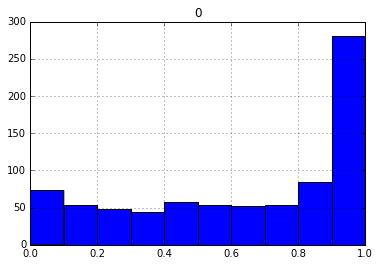

In [102]:
import pandas as pd
%matplotlib inline
preds = pd.DataFrame(predictions)
preds.hist()

In [103]:
validation_generator.class_indices

{'not_pizza': 0, 'pizza': 1}

In [104]:
validation_generator_2 = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=1,
        #save_to_dir='val_aug'
        class_mode='binary',
        shuffle=False)

Found 800 images belonging to 2 classes.


In [75]:
pizzas = glob.glob(validation_data_dir+'/pizza/*.jpg')
not_pizzas = glob.glob(validation_data_dir+'/not_pizza/*.jpg')
print len(pizzas), len(not_pizzas)

400 400


In [105]:
predictions = []
predicted_labels = []
for i, (img, y) in enumerate(validation_generator_2):
    pp = model.predict(img)
    label = int(pp[0] >= 0.5)
    predictions.append(pp[0][0])
    predicted_labels.append(label)
    if i >= 800:
        break

In [106]:
print predictions[0:10]
print predicted_labels[0:10]

[0.01505492, 0.2494195, 0.48538959, 0.17214279, 0.70707059, 0.53252172, 0.95420098, 0.36732924, 0.92302752, 0.14975837]
[0, 0, 0, 0, 1, 1, 1, 0, 1, 0]


In [130]:
len(predicted_labels), len(predictions)

(801, 801)

In [107]:
np.mean([1 if pl == l 
         else 0 for pl, l 
         in zip(predicted_labels, np.zeros(400).tolist()+np.ones(400).tolist())])

0.77625

In [80]:
image_file_predictions = {}
for i, filename in enumerate(not_pizzas+pizzas):
    image_file_predictions[filename] = {
        'predicted_class':predicted_labels[i],
        'predicted_prob_pizza':predictions[i]
    }

In [81]:
image_file_df = pd.DataFrame(image_file_predictions)

In [82]:
image_file_df.T.head()

,predicted_class,predicted_prob_pizza
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1006400.jpg,0.0,0.015055
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1010547.jpg,0.0,0.249419
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1026621.jpg,0.0,0.485390
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/102854.jpg,0.0,0.172143
/Users/VanessaG/Desktop/pizza_class_data/validation/not_pizza/1053345.jpg,1.0,0.707071


In [121]:
actual_labels = list(train_generator.classes)

In [127]:
from sklearn.metrics import classification_report
print(classification_report(????, ?????))


ValueError: Found arrays with inconsistent numbers of samples: [ 801 2000]

In [114]:
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve()

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, 'b',)
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curve')

plt.xlabel('False Positive Rate')
plt.xlim(0,1.0)
plt.ylabel('True Positive Rate')
plt.ylim(0,1.0)

plt.show()

TypeError: roc_curve() takes at least 2 arguments (0 given)

In [111]:
#not as cool as i thought
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')